In [1]:
%reload_ext autoreload
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns


import math


import cPickle as pickle

import datetime




from IPython.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../fashion_mnist_data/")


/scratch/cluster/lty/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../fashion_mnist_data/train-images-idx3-ubyte.gz
Extracting ../fashion_mnist_data/train-labels-idx1-ubyte.gz
Extracting ../fashion_mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../fashion_mnist_data/t10k-labels-idx1-ubyte.gz


In [3]:
def gen_bin_classify_data_MNIST(dig1, dig0, mnist):
    cond_train = np.logical_or(mnist.train.labels == dig1, mnist.train.labels == dig0)
    
    Xtrain = mnist.train.images[cond_train, :]
    Ytrain = np.array(mnist.train.labels[cond_train] == dig1, dtype=np.float)
    
    cond_test = np.logical_or(mnist.test.labels == dig1, mnist.test.labels == dig0)
    
    Xtest = mnist.test.images[cond_test, :]
    Ytest = np.array(mnist.test.labels[cond_test] == dig1, dtype=np.float)
    
    return Xtrain, Ytrain, Xtest, Ytest

In [4]:
import statsmodels.api as sm

/scratch/cluster/lty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
dig1 = 6
dig0 = 0

Xtrain, Ytrain, Xtest, Ytest = gen_bin_classify_data_MNIST(dig1, dig0, mnist)

In [6]:
sm_lr = sm.Logit(Ytrain, sm.add_constant(Xtrain, prepend=False))
sm_lr_fit = sm_lr.fit()

Optimization terminated successfully.
         Current function value: 0.270675
         Iterations 26


In [7]:
print np.mean(Ytrain != (sm_lr_fit.predict(sm.add_constant(Xtrain, prepend=False)) > 0.5))

0.1179185520361991


In [8]:
_, sv_sm_lr_fit_cov_params, _ = np.linalg.svd(sm_lr_fit.cov_params())

<IPython.core.display.Javascript object>


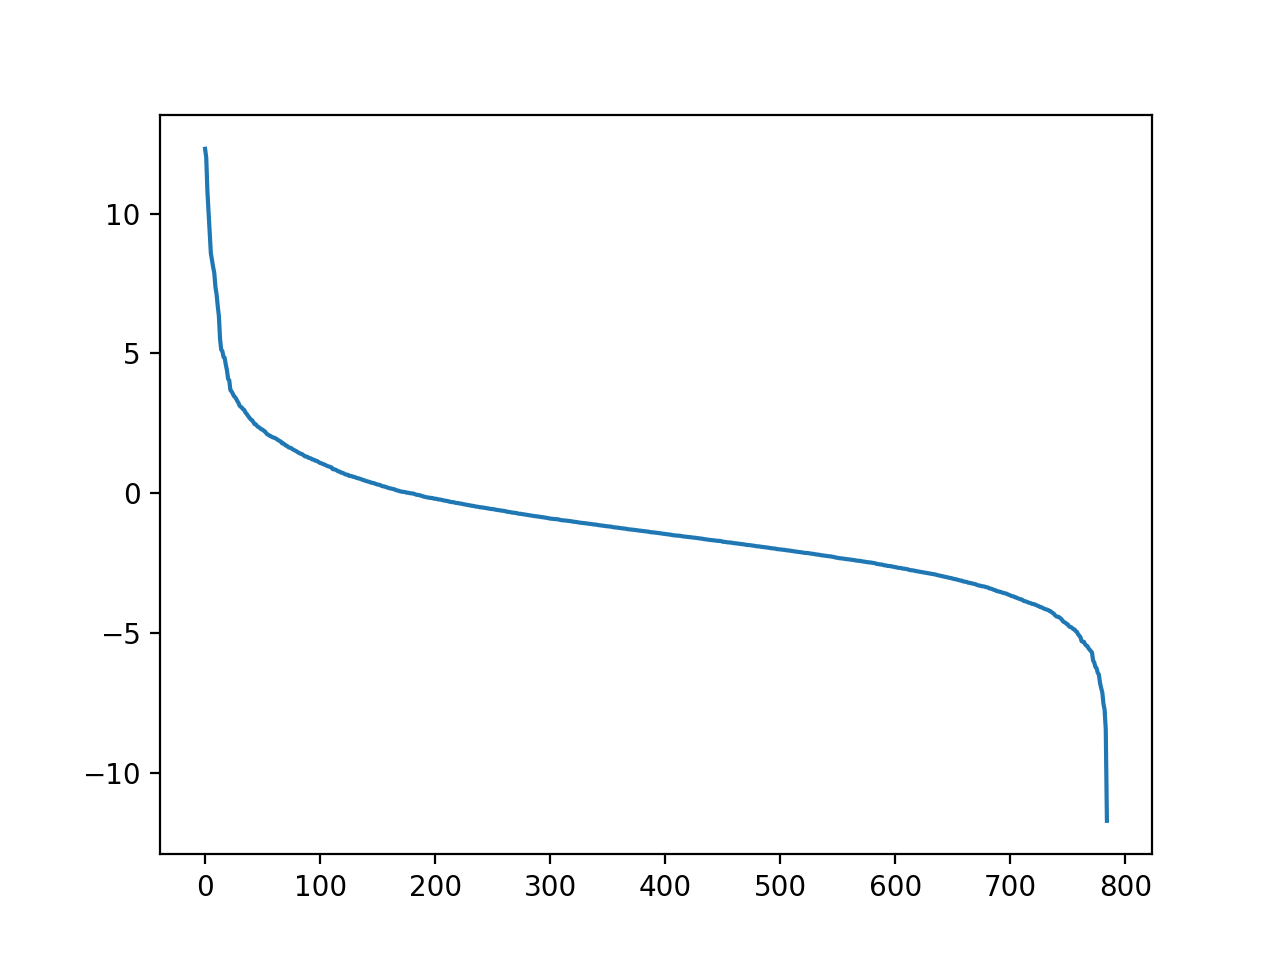

In [9]:
plt.figure()
plt.plot(np.log(sv_sm_lr_fit_cov_params))

In [10]:
# plt.figure()
# plt.imshow(Xtrain[5, :].reshape((28, 28)), cmap="binary", vmax=1, vmin=0)

In [11]:
import tensorflow as tf

In [12]:
ntrain, p = Xtrain.shape
ntest, _ = Xtest.shape

In [13]:
X = tf.placeholder(dtype=tf.float64, shape=[ntrain, p])

Y = tf.placeholder(dtype=tf.float64, shape=[ntrain, 1])




In [14]:
layer_neuron_count = [32]#, 180, 90]

In [15]:
from __future__ import division

K_LASSO_LAMBDA_SCALE = 7.0

lasso_lambda_layer = [K_LASSO_LAMBDA_SCALE * math.sqrt(math.log(p) / ntrain)]


K_LASSO_LOGISTIC = 15.0


for i in xrange(len(layer_neuron_count) - 1):
    lnc_in = layer_neuron_count[i] 
    lnc_out = layer_neuron_count[i + 1]
    lasso_lambda_layer.append(K_LASSO_LAMBDA_SCALE * math.sqrt(math.log(lnc_in * lnc_out) / ntrain))


In [16]:
idx_layers = []


idx_begin = 0

lnc_in = p
for lnc_out in layer_neuron_count:
    
    idx_wbs = []
    
    for j in xrange(lnc_out):
        
        idx_end = idx_begin + lnc_in
        idx_w = (idx_begin, idx_end) 
        idx_begin = idx_end
        
        idx_end = idx_begin + 1
        idx_b = (idx_begin, idx_end)
        idx_begin = idx_end
        
        
        idx_wbs.append((idx_w, idx_b))
    
    
    idx_layers.append(idx_wbs)
    lnc_in = lnc_out

    
    
idx_end = idx_begin + lnc_in    
idx_w_logistic = (idx_begin, idx_end)
idx_begin = idx_end

idx_end = idx_begin + 1
idx_b_logistic = (idx_begin, idx_end)
idx_begin = idx_end

In [17]:



dim_nn = idx_end


tf_param = tf.Variable(tf.random_normal([dim_nn], dtype=tf.float64))






layers = []




layer_input = X

lnc_in = p


train_ops = []

var_all = []

from itertools import izip

for lnc_out, idx_wbs in izip(layer_neuron_count, idx_layers):
    list_layer_output = []
    
    wbs = []
    
    for j, idx_wb in izip(xrange(lnc_out), idx_wbs):
        idx_w = idx_wb[0]
        idx_b = idx_wb[1]
        wi = tf_param[idx_w[0]:idx_w[1]]
        bi = tf_param[idx_b[0]:idx_b[1]]
        
        list_layer_output.append(tf.nn.softplus(tf.matmul(layer_input, tf.reshape(wi, [-1, 1])) + bi))
        
        wbs.append((wi, bi))
    
    layer_output = tf.concat(list_layer_output, axis=1)
    
    layers.append(wbs)
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf_param[idx_w_logistic[0]:idx_w_logistic[1]]
b_logistic = tf_param[idx_b_logistic[0]:idx_b_logistic[1]]

y_logistic = tf.matmul(layer_input, tf.reshape(w_logistic, [-1, 1])) + b_logistic

class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))


def logistic_loss(tf_y_logistic_, tf_Y_):
    return tf.multiply(tf.nn.softplus(-tf_y_logistic_) - tf.nn.softplus(tf_y_logistic_), tf_Y_) + tf.nn.softplus(tf_y_logistic_)



loss = tf.reduce_mean(logistic_loss(y_logistic, Y))



lasso_lambda_logistic = K_LASSO_LOGISTIC * math.sqrt(math.log(lnc_in) / ntrain)





eta_step = float(.01)
tf_eta_step = tf.constant([eta_step], dtype=tf.float64)


def lasso_prox(ts_, prox_):
    ts_prox_ = tf.constant([prox_], dtype=tf.float64)
    return tf.nn.relu(ts_ - ts_prox_) - tf.nn.relu(-ts_ - ts_prox_)




grad_w_logistic = tf.gradients(loss, w_logistic)
train_ops.append(tf.assign(w_logistic, tf.reshape(lasso_prox(w_logistic - tf_eta_step * grad_w_logistic, eta_step * lasso_lambda_logistic), shape=[-1])))

grad_b_logistic = tf.gradients(loss, b_logistic)
train_ops.append(tf.assign(b_logistic, tf.reshape(lasso_prox(b_logistic - tf_eta_step * grad_b_logistic, eta_step * lasso_lambda_logistic), shape=[-1])))



for i in xrange(len(layers)):
    wbs = layers[i]
    ll = lasso_lambda_layer[i]
    
    for wb in wbs:
        wi = wb[0]
        grad_wi = tf.gradients(loss, wi)
        train_ops.append(tf.assign(wi, tf.reshape(lasso_prox(wi - tf_eta_step * grad_wi, eta_step * ll), shape=[-1])))

        bi = wb[1]
        grad_bi = tf.gradients(loss, bi)
        train_ops.append(tf.assign(bi, tf.reshape(lasso_prox(bi - tf_eta_step * grad_bi, eta_step * ll), shape=[-1])))
    









train_ops.append(loss)



In [18]:
num_train_iter = 800    

loss_train = []


time_start = datetime.datetime.now()

class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))


sess = tf.Session()

sess.run(tf.global_variables_initializer())

print "train loss -- start"
print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})

for _ in xrange(num_train_iter):

    sess_run = sess.run(train_ops, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
    loss_train.append(sess_run[-1])





print "train loss -- end"
print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})

print "test err"
eval_class_err = sess.run(class_err, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))}) / ntrain
print eval_class_err
        
        



time_end = datetime.datetime.now()

train loss -- start
23.21204557487952
train loss -- end
0.6276203238057982
test err
0.2398190045248869


<IPython.core.display.Javascript object>


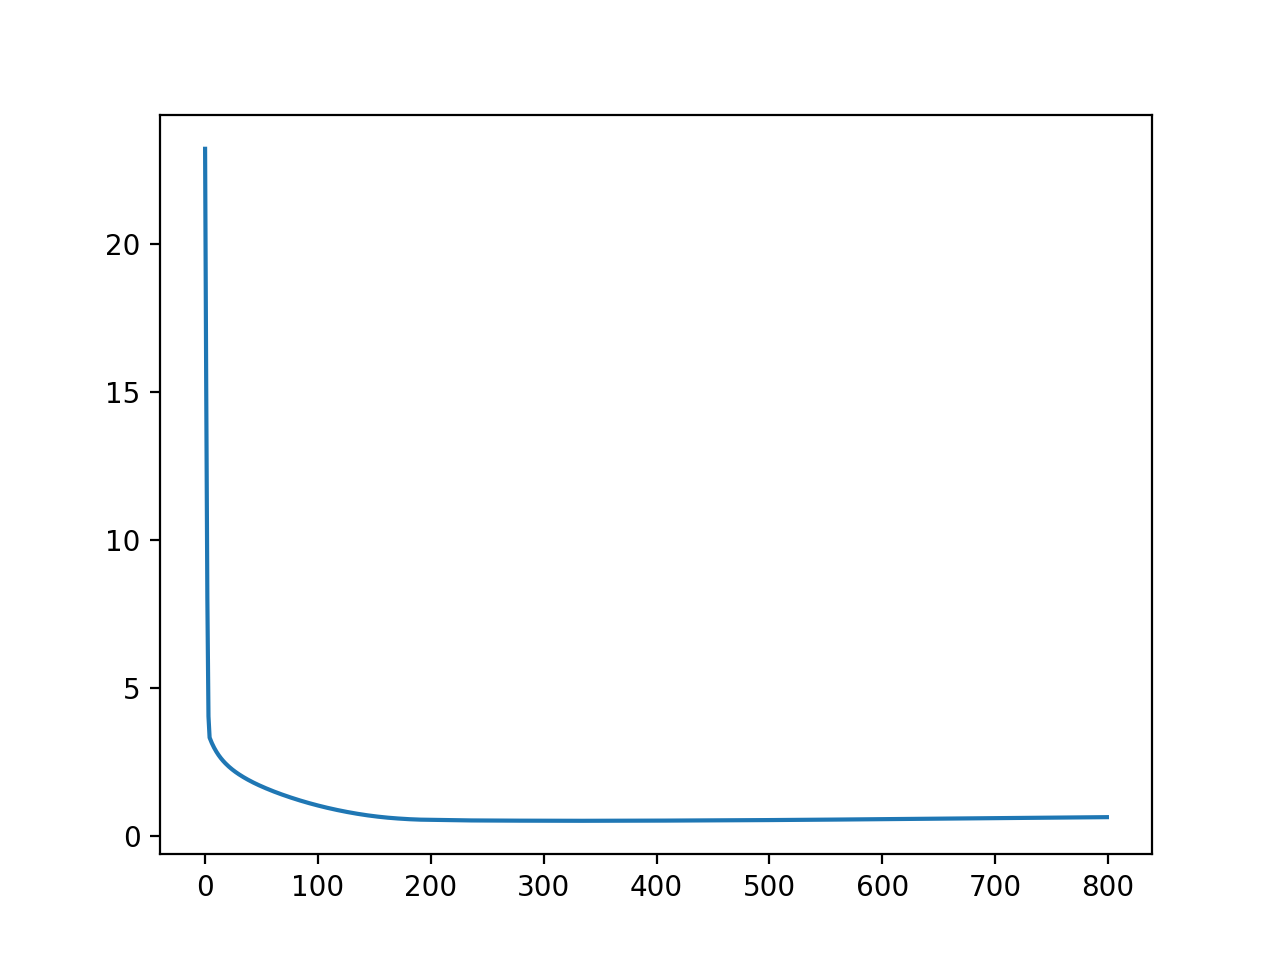

In [19]:
plt.figure()
plt.plot(loss_train)


In [20]:
print time_end - time_start
print eval_class_err

0:03:39.104878
0.2398190045248869


In [21]:
np_tf_param = np.array(sess.run(tf_param))
zero_tf_param = np_tf_param == 0


# zero_logistic_w = []

# np_b_logistic= b_logistic.eval(session=sess)
# if np_b_logistic == 0:
#     zero_logistic_b = True
# else:
#     zero_logistic_b = False
# np_w_logistic = np.array(w_logistic.eval(session=sess))
# zero_logistic_w = np_w_logistic == 0


# zero_layers = []
# np_layers = []
# for wbs in layers:
#     np_wb = []
#     zero_wb = []
#     for wb in wbs:
#         w = wb[0]
#         b = wb[1]
#         np_w = np.array(w.eval(session=sess))
#         np_b = np.array(b.eval(session=sess))
#         zero_w = np_w == 0
#         zero_b = np_b == 0
#         np_wb.append((np_w, np_b))
#         zero_wb.append((zero_w, zero_b))
        
#     np_layers.append(np_wb)
#     zero_layers.append(zero_wb)

In [22]:
print np.sum(1 - zero_tf_param)
print ntrain

4191
11050


In [23]:
sess.close()

In [24]:

X = tf.placeholder(dtype=tf.float64, shape=[ntrain, p])

Y = tf.placeholder(dtype=tf.float64, shape=[ntrain, 1])





tf_param = tf.Variable(tf.random_normal([dim_nn], dtype=tf.float64))






layers = []




layer_input = X

lnc_in = p


train_ops = []



from itertools import izip

for lnc_out, idx_wbs in izip(layer_neuron_count, idx_layers):
    list_layer_output = []
    
    wbs = []
    
    for j, idx_wb in izip(xrange(lnc_out), idx_wbs):
        idx_w = idx_wb[0]
        idx_b = idx_wb[1]
        wi = tf_param[idx_w[0]:idx_w[1]]
        bi = tf_param[idx_b[0]:idx_b[1]]
        
        list_layer_output.append(tf.nn.softplus(tf.matmul(layer_input, tf.reshape(wi, [-1, 1])) + bi))
        
        wbs.append((wi, bi))
    
    layer_output = tf.concat(list_layer_output, axis=1)
    
    layers.append(wbs)
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf_param[idx_w_logistic[0]:idx_w_logistic[1]]
b_logistic = tf_param[idx_b_logistic[0]:idx_b_logistic[1]]

y_logistic = tf.matmul(layer_input, tf.reshape(w_logistic, [-1, 1])) + b_logistic

class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))





loss = tf.reduce_mean(logistic_loss(y_logistic, Y))








In [25]:
from itertools import izip

time_start_1 = datetime.datetime.now()

num_train_iter_1 = 8000 



class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))







init_assign_op = tf.assign(tf_param, np_tf_param)

        


tfph_param = tf.placeholder(shape=tf_param.shape.as_list(), dtype=tf.float64)


sparse_tf_param_op = tf.assign(tf_param, tfph_param)



eta_step = float(2.0)

loss_train_1 = []

grad_tf_param = tf.gradients(loss, tf_param)

train_op = tf.assign(tf_param, tf.reshape(tf_param - tf_eta_step * grad_tf_param, shape=[-1]))

sess = tf.Session()

sess.run(tf.global_variables_initializer())

        
sess.run(init_assign_op)

print "train loss -- start"
print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
        


for _ in xrange(num_train_iter_1):


    sess_run = sess.run([train_op, loss], feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})
    loss_train_1.append(sess_run[-1])

 
    
    eval_tf_param = np.array(sess.run(tf_param))
    eval_tf_param[zero_tf_param] = 0
    sess.run(sparse_tf_param_op, feed_dict={tfph_param: eval_tf_param})
    



print "train loss -- end"
print sess.run(loss, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})

print "test err"
eval_class_err_1 = sess.run(class_err, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))}) / ntrain
print eval_class_err_1
        
        



time_end_1 = datetime.datetime.now()

train loss -- start
0.6276203238057982
train loss -- end
0.3876393710562813
test err
0.17619909502262443


In [26]:
print "test err"
eval_class_err_1 = sess.run(class_err, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))}) / ntrain


test err


In [27]:
print eval_class_err_1
print time_end_1 - time_start_1

0.17619909502262443
0:21:34.801877


<IPython.core.display.Javascript object>


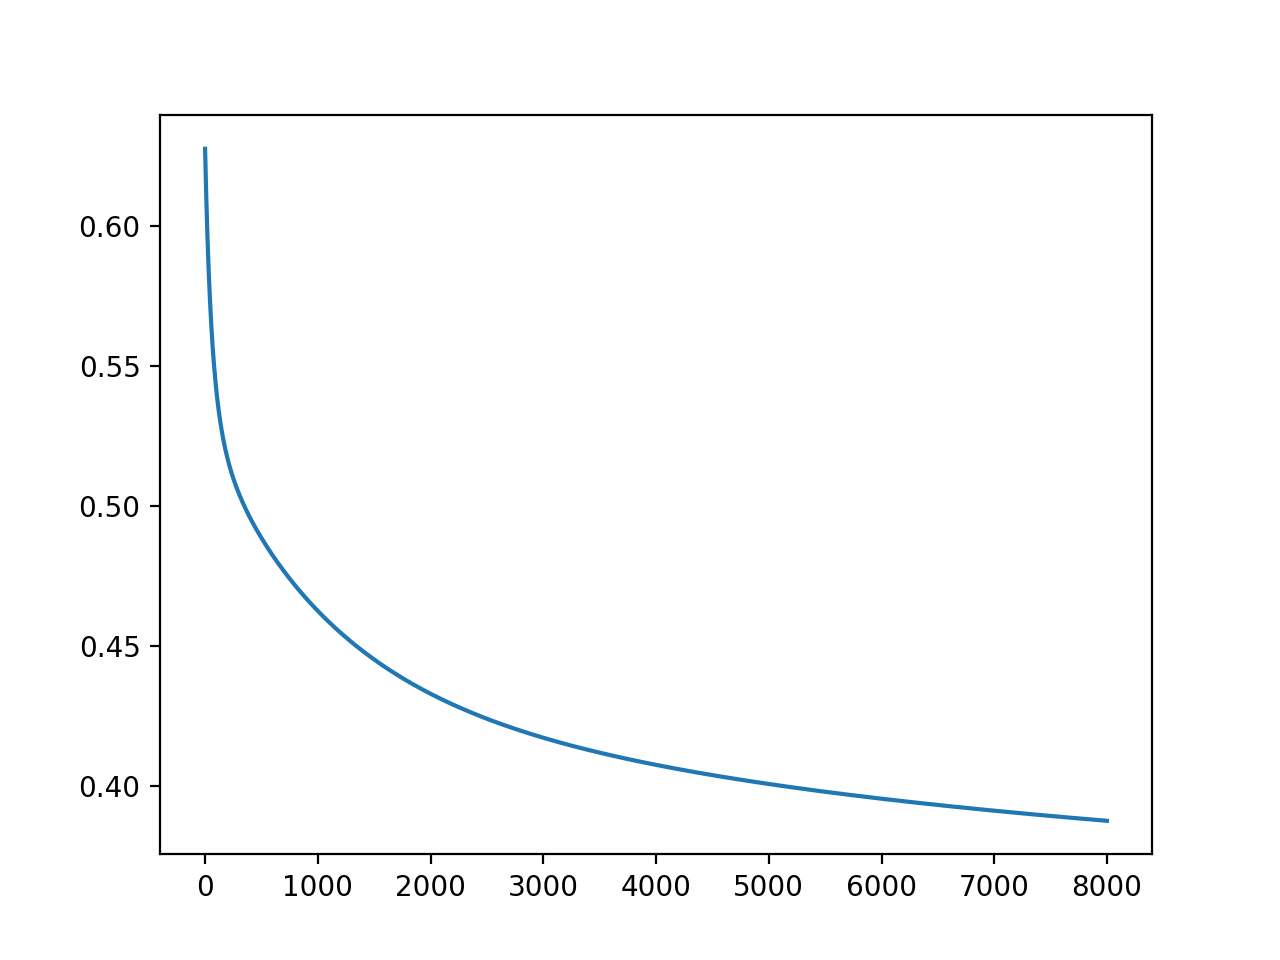

In [28]:
plt.figure()
plt.plot(loss_train_1)


In [29]:
import pickle

In [30]:
pickle.dump({"tf_param": eval_tf_param}, open("./PARAMS-nn-2l-mnist-lasso-adversarial-CI_1vec-narsil_8", 'w'))

In [31]:
sess.close()

In [32]:

X = tf.placeholder(dtype=tf.float64, shape=[ntrain, p])

Y = tf.placeholder(dtype=tf.float64, shape=[ntrain, 1])

tf_adv = tf.Variable(tf.zeros([1, p], dtype=tf.float64), trainable=False)



tf_param = tf.Variable(tf.random_normal([dim_nn], dtype=tf.float64))






layers = []




layer_input = X + tf_adv

lnc_in = p


train_ops = []



from itertools import izip

for lnc_out, idx_wbs in izip(layer_neuron_count, idx_layers):
    list_layer_output = []
    
    wbs = []
    
    for j, idx_wb in izip(xrange(lnc_out), idx_wbs):
        idx_w = idx_wb[0]
        idx_b = idx_wb[1]
        wi = tf_param[idx_w[0]:idx_w[1]]
        bi = tf_param[idx_b[0]:idx_b[1]]
        
        list_layer_output.append(tf.nn.softplus(tf.matmul(layer_input, tf.reshape(wi, [-1, 1])) + bi))
        
        wbs.append((wi, bi))
    
    layer_output = tf.concat(list_layer_output, axis=1)
    
    layers.append(wbs)
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf_param[idx_w_logistic[0]:idx_w_logistic[1]]
b_logistic = tf_param[idx_b_logistic[0]:idx_b_logistic[1]]

y_logistic = tf.matmul(layer_input, tf.reshape(w_logistic, [-1, 1])) + b_logistic

class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))





loss = tf.reduce_mean(logistic_loss(y_logistic, Y))








In [33]:





tf_adv_grad = tf.gradients(loss, tf_adv)




init_assign_op = tf.assign(tf_param, eval_tf_param)

        



sess = tf.Session()

sess.run(tf.global_variables_initializer())

        
sess.run(init_assign_op)

        
np_adv_grad = np.array(sess.run(tf_adv_grad, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))}))


    



        





<IPython.core.display.Javascript object>


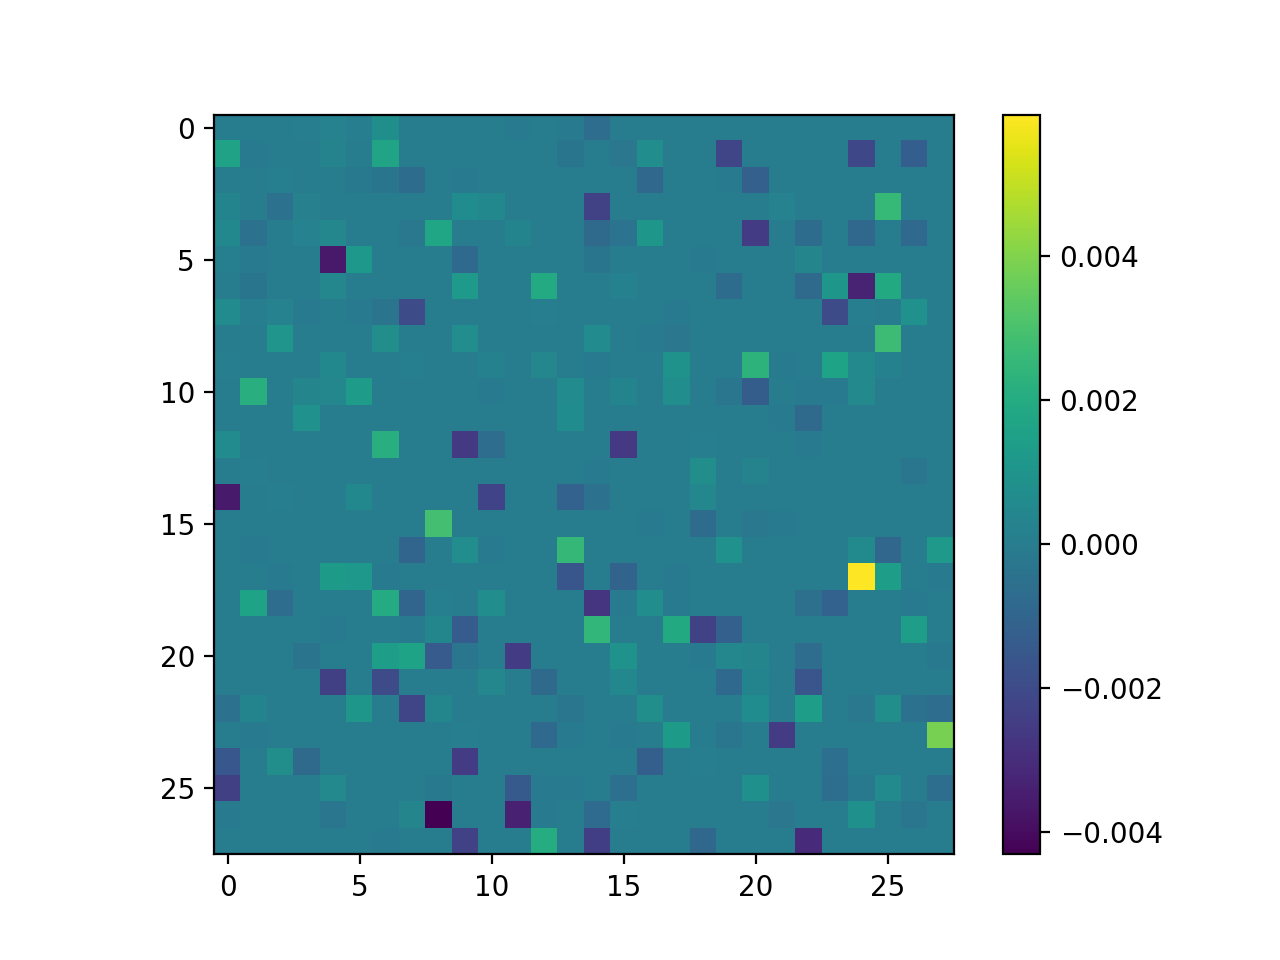

In [34]:
plt.figure()
plt.imshow(np_adv_grad.reshape((28, 28)))
plt.colorbar()

In [35]:

X = tf.placeholder(dtype=tf.float64, shape=[None, p])

Y = tf.placeholder(dtype=tf.float64, shape=[None, 1])



tf_param = tf.Variable(tf.random_normal([dim_nn], dtype=tf.float64))






layers = []




layer_input = X 

lnc_in = p


train_ops = []



from itertools import izip

for lnc_out, idx_wbs in izip(layer_neuron_count, idx_layers):
    list_layer_output = []
    
    wbs = []
    
    for j, idx_wb in izip(xrange(lnc_out), idx_wbs):
        idx_w = idx_wb[0]
        idx_b = idx_wb[1]
        wi = tf_param[idx_w[0]:idx_w[1]]
        bi = tf_param[idx_b[0]:idx_b[1]]
        
        list_layer_output.append(tf.nn.softplus(tf.matmul(layer_input, tf.reshape(wi, [-1, 1])) + bi))
        
        wbs.append((wi, bi))
    
    layer_output = tf.concat(list_layer_output, axis=1)
    
    layers.append(wbs)
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf_param[idx_w_logistic[0]:idx_w_logistic[1]]
b_logistic = tf_param[idx_b_logistic[0]:idx_b_logistic[1]]

y_logistic = tf.matmul(layer_input, tf.reshape(w_logistic, [-1, 1])) + b_logistic



loss = tf.reduce_mean(logistic_loss(y_logistic, Y))




init_assign_op = tf.assign(tf_param, eval_tf_param)

        
tf_H = tf.hessians(loss, tf_param)
tf_Gi = tf.gradients(loss, tf_param)


sess = tf.Session()

sess.run(tf.global_variables_initializer())

        
sess.run(init_assign_op)




array([ 0.        , -1.48079808,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [36]:
time_start_2 = datetime.datetime.now()

eval_H = sess.run(tf_H, feed_dict={X: Xtrain, Y: Ytrain.reshape((-1, 1))})

time_end_2 = datetime.datetime.now()

In [37]:
print time_start_2
print time_end_2
print time_end_2 - time_start_2  

2018-04-26 14:16:07.780822
2018-04-26 15:21:04.282070
1:04:56.501248


In [38]:
np_H = np.array(eval_H[0])
print np_H.shape

(25153, 25153)


In [39]:
time_start_3 = datetime.datetime.now()


list_Gi_sess_run = []

for i in xrange(ntrain):
    list_Gi_sess_run.append(sess.run(tf_Gi, feed_dict={X: Xtrain[i, :].reshape((1, -1)), Y: Ytrain[i].reshape((-1, 1))}))


time_end_3 = datetime.datetime.now()

In [40]:
print time_start_3
print time_end_3
print time_end_3 - time_start_3  

2018-04-26 15:21:06.509991
2018-04-26 15:23:23.459585
0:02:16.949594


In [41]:
np_Gi_all = np.array([gi[0].ravel() for gi in list_Gi_sess_run])

In [42]:

# _, sv_np_H, _ = np.linalg.svd(np_H)


In [43]:
# plt.figure()
# plt.plot(sv_np_H)
# plt.figure()
# plt.plot(np.log(sv_np_H))

In [44]:
np_H_bak = np_H.copy()
np_H[zero_tf_param, zero_tf_param] = 0

In [45]:

# _, sv_np_H, _ = np.linalg.svd(np_H)


In [46]:
# plt.figure()
# plt.plot(sv_np_H)
# plt.figure()
# plt.plot(np.log(sv_np_H))

In [47]:
np_Gi_all_bak = np_Gi_all.copy()
np_Gi_all[:, zero_tf_param] = 0

In [48]:
# from __future__ import division

# cov_G = np.zeros((dim_nn, dim_nn))

# for i in xrange(ntrain):
#     gi = np_Gi_all[i, :].reshape((-1, 1))
#     cov_G = cov_G + gi.dot(gi.T)

# cov_G = cov_G / ntrain


In [49]:
support_tf_param = np.logical_not(zero_tf_param)

In [50]:
support_H = np_H[support_tf_param, :][:, support_tf_param]
support_Gi_all = np_Gi_all[:, support_tf_param]

In [51]:
print np.linalg.cond(support_H)

inf


/scratch/cluster/lty/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


In [52]:

_, sv_support_H, _ = np.linalg.svd(support_H)


<IPython.core.display.Javascript object>


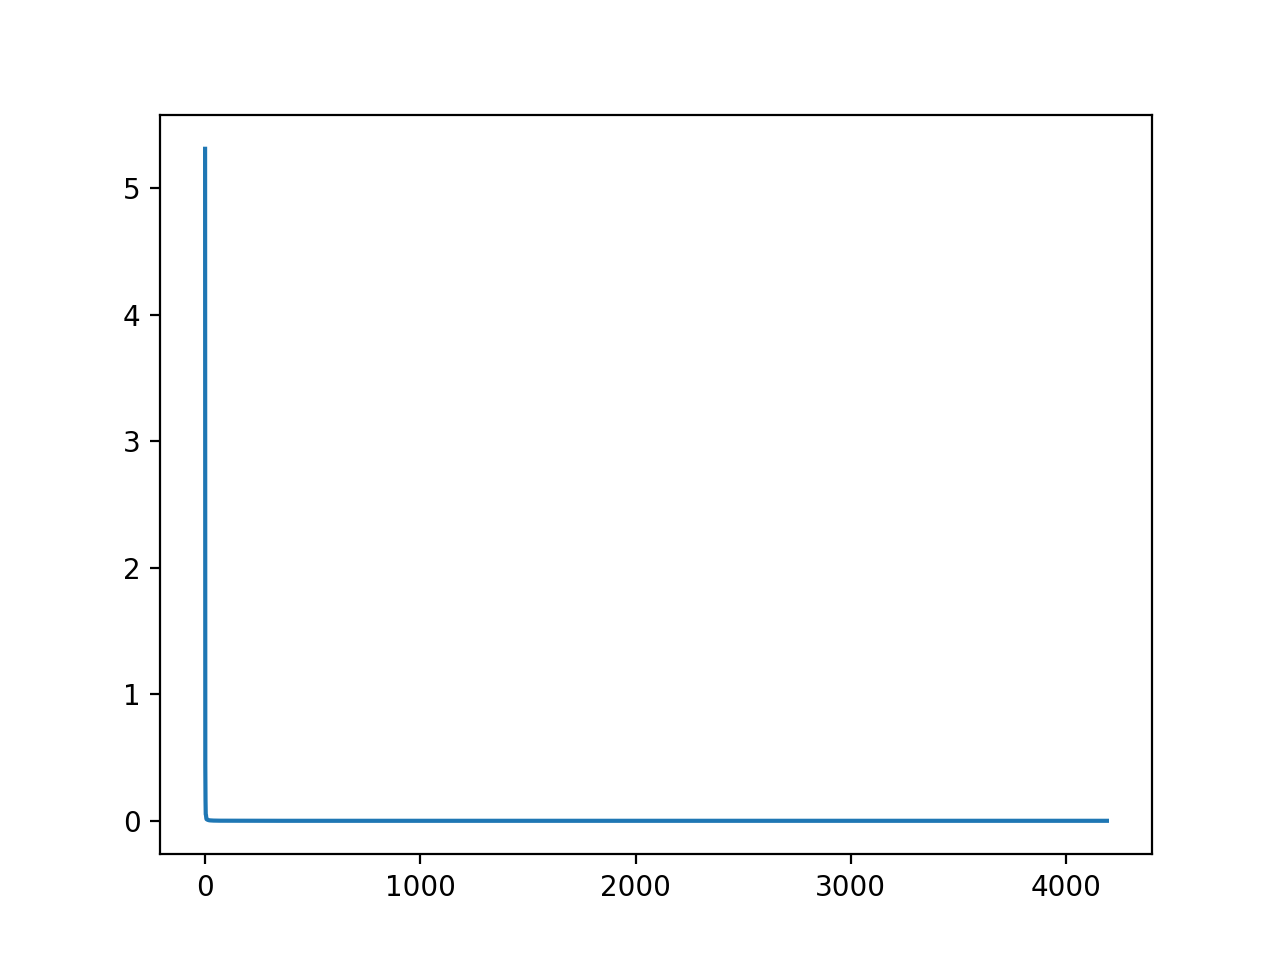

<IPython.core.display.Javascript object>


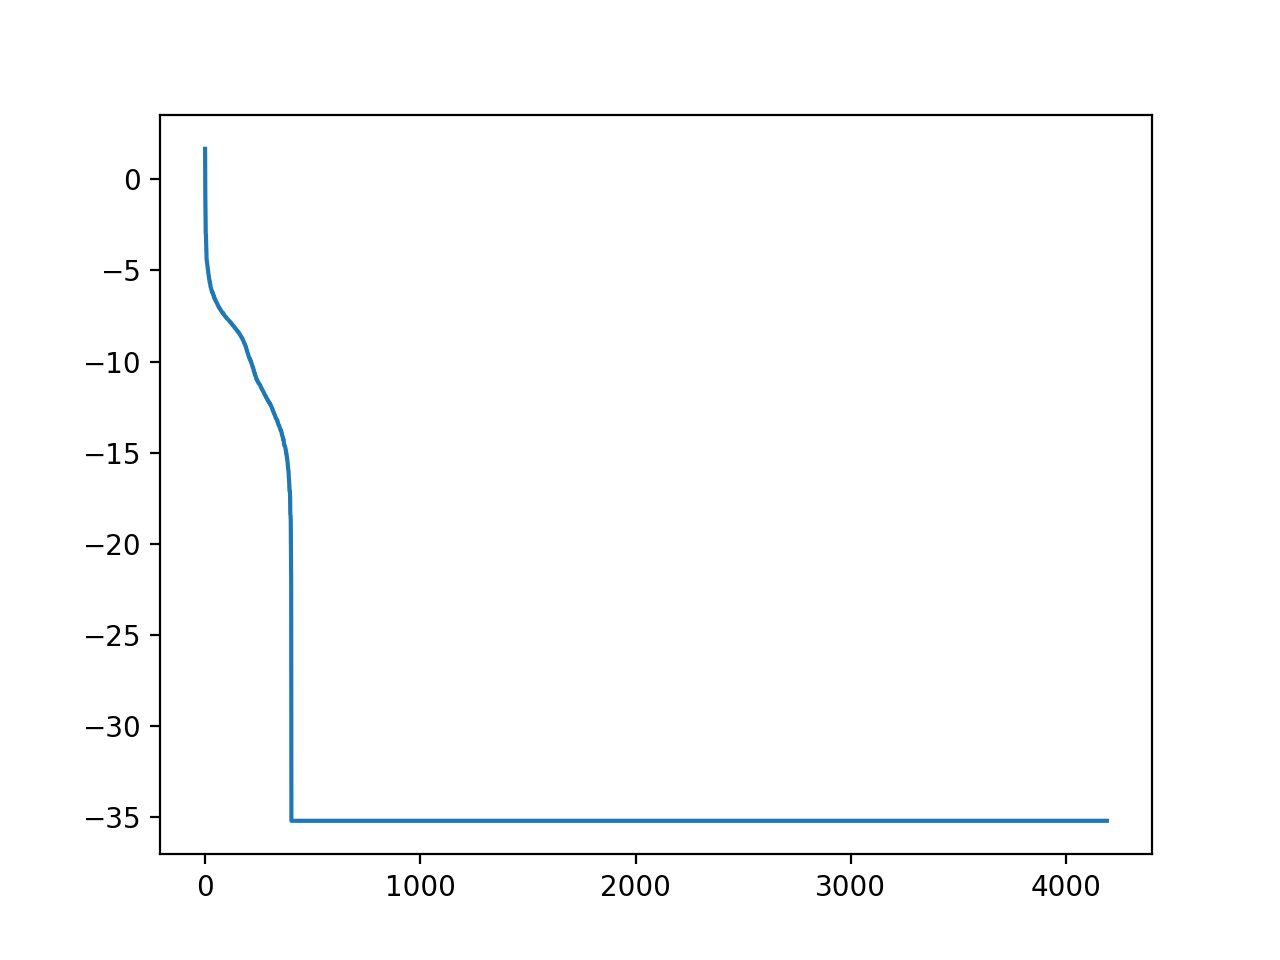

In [53]:
plt.figure()
plt.plot(sv_support_H)
plt.figure()
plt.plot(np.log(sv_support_H))

In [57]:
sess.close()

In [113]:

X = tf.placeholder(dtype=tf.float64, shape=[1, p])

Y = tf.placeholder(dtype=tf.float64, shape=[1, 1])

tf_adv = tf.Variable(tf.zeros([1, p], dtype=tf.float64), trainable=False)



tf_param = tf.Variable(tf.random_normal([dim_nn], dtype=tf.float64))






layers = []




layer_input = X + tf_adv

lnc_in = p


train_ops = []



from itertools import izip

for lnc_out, idx_wbs in izip(layer_neuron_count, idx_layers):
    list_layer_output = []
    
    wbs = []
    
    for j, idx_wb in izip(xrange(lnc_out), idx_wbs):
        idx_w = idx_wb[0]
        idx_b = idx_wb[1]
        wi = tf_param[idx_w[0]:idx_w[1]]
        bi = tf_param[idx_b[0]:idx_b[1]]
        
        list_layer_output.append(tf.nn.softplus(tf.matmul(layer_input, tf.reshape(wi, [-1, 1])) + bi))
        
        wbs.append((wi, bi))
    
    layer_output = tf.concat(list_layer_output, axis=1)
    
    layers.append(wbs)
    layer_input = layer_output
    lnc_in = lnc_out

w_logistic = tf_param[idx_w_logistic[0]:idx_w_logistic[1]]
b_logistic = tf_param[idx_b_logistic[0]:idx_b_logistic[1]]

y_logistic = tf.matmul(layer_input, tf.reshape(w_logistic, [-1, 1])) + b_logistic

class_err = tf.count_nonzero(tf.not_equal(tf.greater(y_logistic, tf.constant([0], dtype=tf.float64)), tf.greater(Y, tf.constant([.5], dtype=tf.float64))))





loss = tf.reduce_mean(logistic_loss(y_logistic, Y))







In [114]:



tfph_adv = tf.placeholder(dtype=tf.float64, shape=[1, p])

adv_assign_op = tf.assign(tf_adv, tfph_adv)



tf_loss_grad_param = tf.gradients(loss, tf_param)

tf_y_logistic_grad_param = tf.gradients(y_logistic, tf_param)


init_assign_op = tf.assign(tf_param, eval_tf_param)

        



sess = tf.Session()

sess.run(tf.global_variables_initializer())

        
sess.run(init_assign_op)

        




array([ 0.        , -1.48079808,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [115]:
my_idx = 0

myX = Xtrain[my_idx, :].reshape((1, -1))
myY = Ytrain[my_idx].reshape((1, 1))

eps_adv = 20.0

adv_X = myX + eps_adv * np_adv_grad.reshape((1, -1))



plt.figure()
plt.imshow(myX.reshape((28, 28)))
plt.figure()
plt.imshow(adv_X.reshape((28, 28)))

print myY

sess.run(adv_assign_op, feed_dict={tfph_adv: np.zeros((1, p))})

run_orig = sess.run(y_logistic, feed_dict={X: myX, Y: myY})
run_adv = sess.run(y_logistic, feed_dict={X: adv_X, Y: myY})

print "orig", run_orig
print "adv", run_adv

run_grad_orig = sess.run(tf_y_logistic_grad_param, feed_dict={X: myX, Y: myY})
run_grad_adv = sess.run(tf_y_logistic_grad_param, feed_dict={X: adv_X, Y: myY})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[0.]]
orig [[-0.3787579]]
adv [[0.1615935]]


In [ ]:
from __future__ import division

support_cov_G = np.zeros(support_H.shape)

for i in xrange(ntrain):
    gi = support_Gi_all[i, :].reshape((-1, 1))
    support_cov_G = support_cov_G + gi.dot(gi.T)

    
support_cov_G = support_cov_G / ntrain

In [ ]:
# np.savez_compressed("./RES_nn-2l-mnist-lasso-adversarial-CI_1vec-narsil_8--support_H", support_H)

In [ ]:
# np.savez_compressed("./RES_nn-2l-mnist-lasso-adversarial-CI_1vec-narsil_8--support_cov_G", support_cov_G)

In [ ]:
from __future__ import division

pinv_support_H = np.linalg.pinv(support_H)

cov_stat = pinv_support_H.T.dot(support_cov_G).dot(pinv_support_H)

In [130]:
support_run_grad_adv = run_grad_adv[0][support_tf_param].reshape((-1, 1))
support_run_grad_orig = run_grad_orig[0][support_tf_param].reshape((-1, 1))

In [131]:
pinv_cov_stat = np.linalg.pinv(cov_stat)

In [132]:
print np.linalg.norm(support_run_grad_orig - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_orig)) \
    / np.linalg.norm(support_run_grad_orig)

0.0008212160134903089


In [133]:
print np.linalg.norm(support_run_grad_adv - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_adv)) \
    / np.linalg.norm(support_run_grad_adv)

0.0015368643600284474


In [ ]:
my_idx = 2

myX = Xtrain[my_idx, :].reshape((1, -1))
myY = Ytrain[my_idx].reshape((1, 1))

eps_adv = 20.0

adv_X = myX + eps_adv * np_adv_grad.reshape((1, -1))



plt.figure()
plt.imshow(myX.reshape((28, 28)))
plt.figure()
plt.imshow(adv_X.reshape((28, 28)))

print myY

sess.run(adv_assign_op, feed_dict={tfph_adv: np.zeros((1, p))})

run_orig = sess.run(y_logistic, feed_dict={X: myX, Y: myY})
run_adv = sess.run(y_logistic, feed_dict={X: adv_X, Y: myY})

print "orig", run_orig
print "adv", run_adv

run_grad_orig = sess.run(tf_y_logistic_grad_param, feed_dict={X: myX, Y: myY})
run_grad_adv = sess.run(tf_y_logistic_grad_param, feed_dict={X: adv_X, Y: myY})


support_run_grad_adv = run_grad_adv[0][support_tf_param].reshape((-1, 1))
support_run_grad_orig = run_grad_orig[0][support_tf_param].reshape((-1, 1))


print np.linalg.norm(support_run_grad_orig - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_orig)) \
    / np.linalg.norm(support_run_grad_orig)
    
print np.linalg.norm(support_run_grad_adv - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_adv)) \
    / np.linalg.norm(support_run_grad_adv)

In [ ]:
my_idx = 10

myX = Xtrain[my_idx, :].reshape((1, -1))
myY = Ytrain[my_idx].reshape((1, 1))

eps_adv = 100.0

adv_X = myX + eps_adv * np_adv_grad.reshape((1, -1))



plt.figure()
plt.imshow(myX.reshape((28, 28)))
plt.figure()
plt.imshow(adv_X.reshape((28, 28)))

print myY

sess.run(adv_assign_op, feed_dict={tfph_adv: np.zeros((1, p))})

run_orig = sess.run(y_logistic, feed_dict={X: myX, Y: myY})
run_adv = sess.run(y_logistic, feed_dict={X: adv_X, Y: myY})

print "orig", run_orig
print "adv", run_adv

run_grad_orig = sess.run(tf_y_logistic_grad_param, feed_dict={X: myX, Y: myY})
run_grad_adv = sess.run(tf_y_logistic_grad_param, feed_dict={X: adv_X, Y: myY})


support_run_grad_adv = run_grad_adv[0][support_tf_param].reshape((-1, 1))
support_run_grad_orig = run_grad_orig[0][support_tf_param].reshape((-1, 1))


print np.linalg.norm(support_run_grad_orig - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_orig)) \
    / np.linalg.norm(support_run_grad_orig)
    
print np.linalg.norm(support_run_grad_adv - cov_stat.dot(pinv_cov_stat).dot(support_run_grad_adv)) \
    / np.linalg.norm(support_run_grad_adv)

In [140]:

sess.run(adv_assign_op, feed_dict={tfph_adv: np.zeros((1, p))})


proj_cov = cov_stat.dot(pinv_cov_stat)

all_rem_cmp_orig_adv = []

l2_norm_adv_grad = np.linalg.norm(np_adv_grad)


for my_idx in xrange(ntrain):
    
    myX = Xtrain[my_idx, :].reshape((1, -1))
    myY = Ytrain[my_idx].reshape((1, 1))
    
    run_orig = sess.run(y_logistic, feed_dict={X: myX, Y: myY})
    
    if (run_orig[0, 0] > 0 and myY[0, 0] < 0.5) or (run_orig[0, 0] < 0 and myY[0, 0] > 0.5):
        continue
    
    run_grad_orig = sess.run(tf_y_logistic_grad_param, feed_dict={X: myX, Y: myY})
    
    eps = 2.0
    
    for _ in xrange(10):
        adv_X = myX + eps_adv * np_adv_grad.reshape((1, -1))
        
        run_adv = sess.run(y_logistic, feed_dict={X: adv_X, Y: myY})
        if run_orig[0, 0] * run_adv[0, 0] <= 0:
            break
            
        
        eps = 2.0 * eps
        
        
    

    run_grad_adv = sess.run(tf_y_logistic_grad_param, feed_dict={X: adv_X, Y: myY})

    support_run_grad_adv = run_grad_adv[0][support_tf_param].reshape((-1, 1))
    support_run_grad_orig = run_grad_orig[0][support_tf_param].reshape((-1, 1))
    
    rand_sphere = np.random.normal(size=myX.shape)
    rand_sphere = rand_sphere / np.linalg.norm(rand_sphere)
    rand_X = myX + eps * l2_norm_adv_grad * rand_sphere
    
    run_grad_rand = sess.run(tf_y_logistic_grad_param, feed_dict={X: rand_X, Y: myY})
    support_run_grad_rand = run_grad_rand[0][support_tf_param].reshape((-1, 1))
    
    rem_rand = np.linalg.norm(support_run_grad_rand - proj_cov.dot(support_run_grad_rand)) \
        / np.linalg.norm(support_run_grad_rand)
    

    rem_orig = np.linalg.norm(support_run_grad_orig - proj_cov.dot(support_run_grad_orig)) \
        / np.linalg.norm(support_run_grad_orig)
    
    rem_adv = np.linalg.norm(support_run_grad_adv - proj_cov.dot(support_run_grad_adv)) \
        / np.linalg.norm(support_run_grad_adv)
    
    
    
    all_rem_cmp_orig_adv.append((rem_orig, rem_adv, rem_rand))
    

In [141]:
np_all_rem_cmp_orig_adv = np.array(all_rem_cmp_orig_adv)

<IPython.core.display.Javascript object>


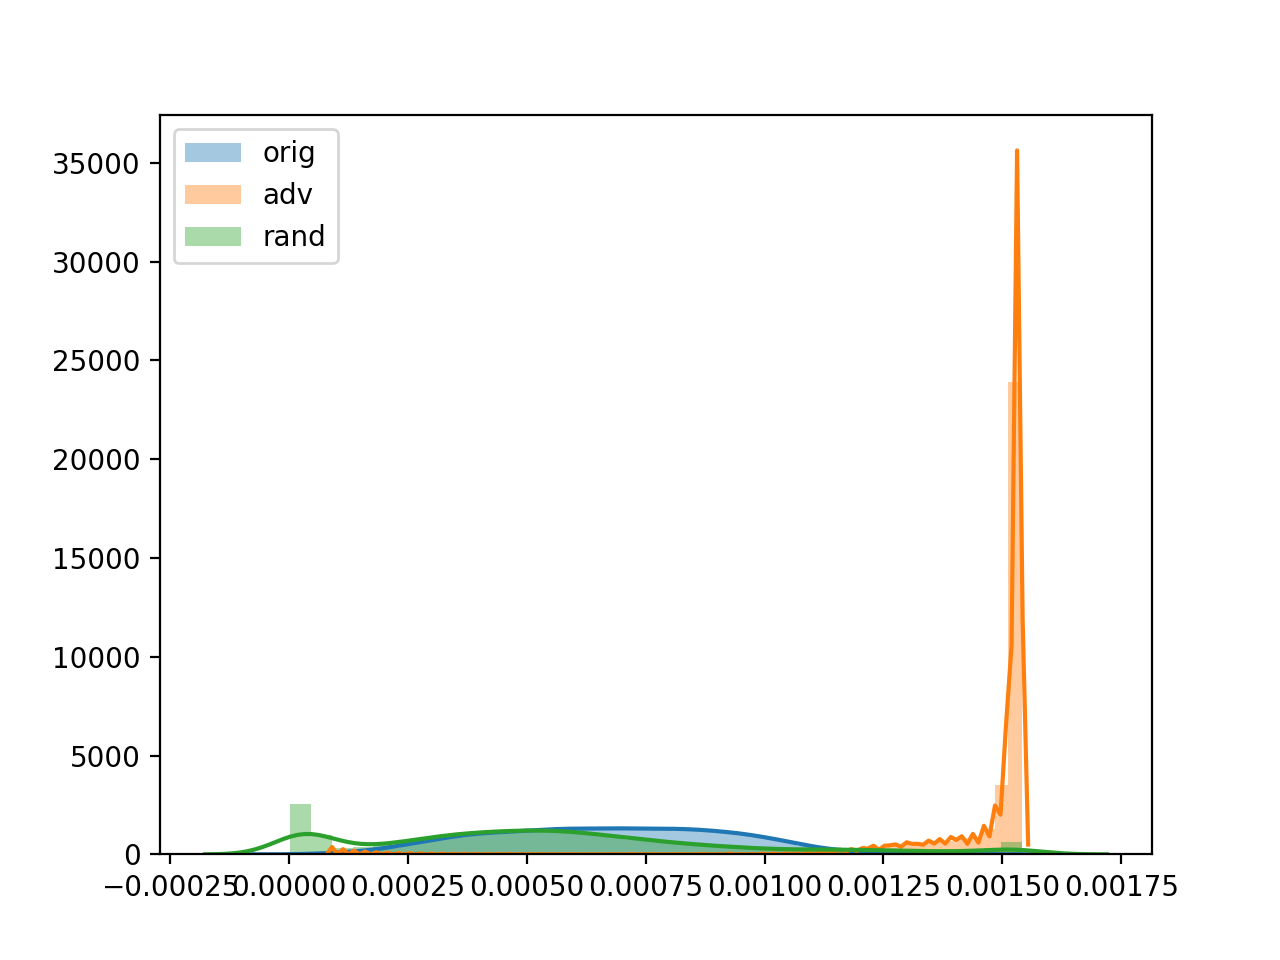

In [142]:
plt.figure()
sns.distplot(np_all_rem_cmp_orig_adv[:, 0], label="orig")
sns.distplot(np_all_rem_cmp_orig_adv[:, 1], label="adv")
sns.distplot(np_all_rem_cmp_orig_adv[:, 2], label="rand")
plt.legend()

In [143]:
np_all_rem_cmp_orig_adv.shape

(9103, 3)

<IPython.core.display.Javascript object>


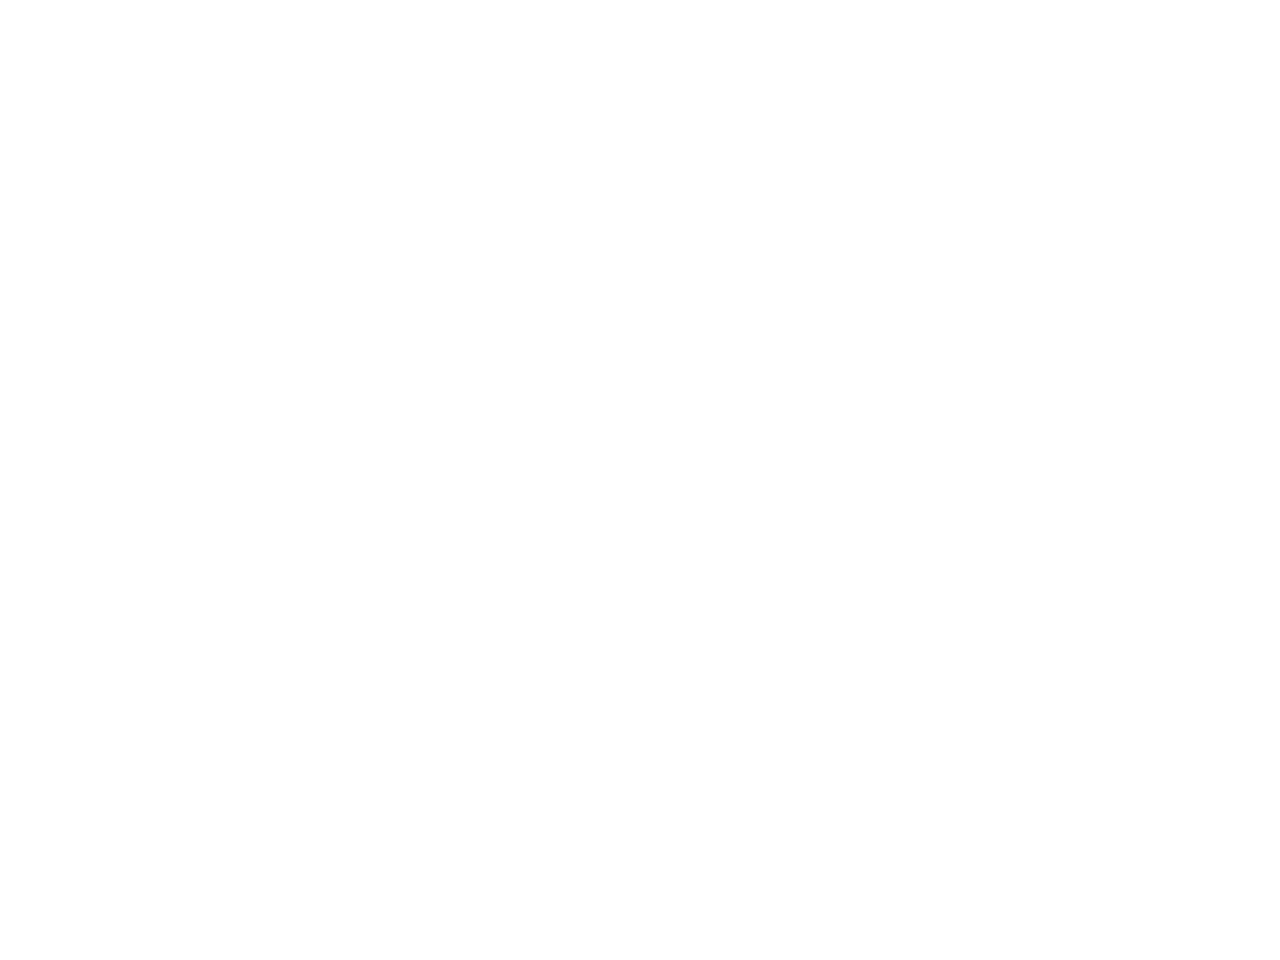

<IPython.core.display.Javascript object>


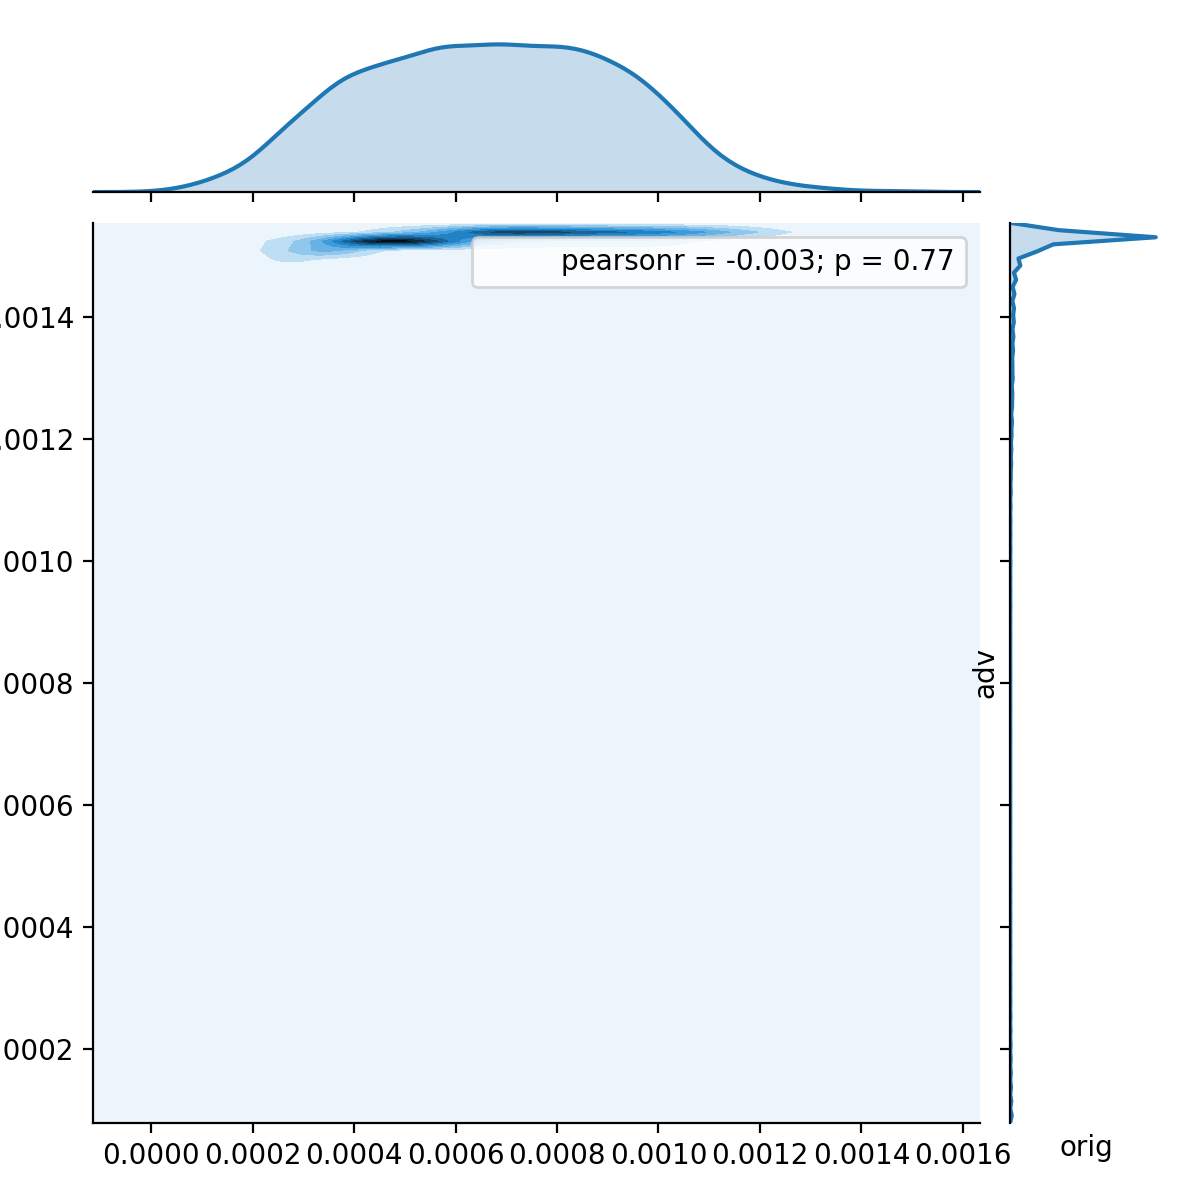

Text(468.016,0.5,'adv')

In [146]:
plt.figure()
sns.jointplot(np_all_rem_cmp_orig_adv[:, 0], np_all_rem_cmp_orig_adv[:, 1], kind="kde")
plt.xlabel("orig")
plt.ylabel("adv")

<IPython.core.display.Javascript object>


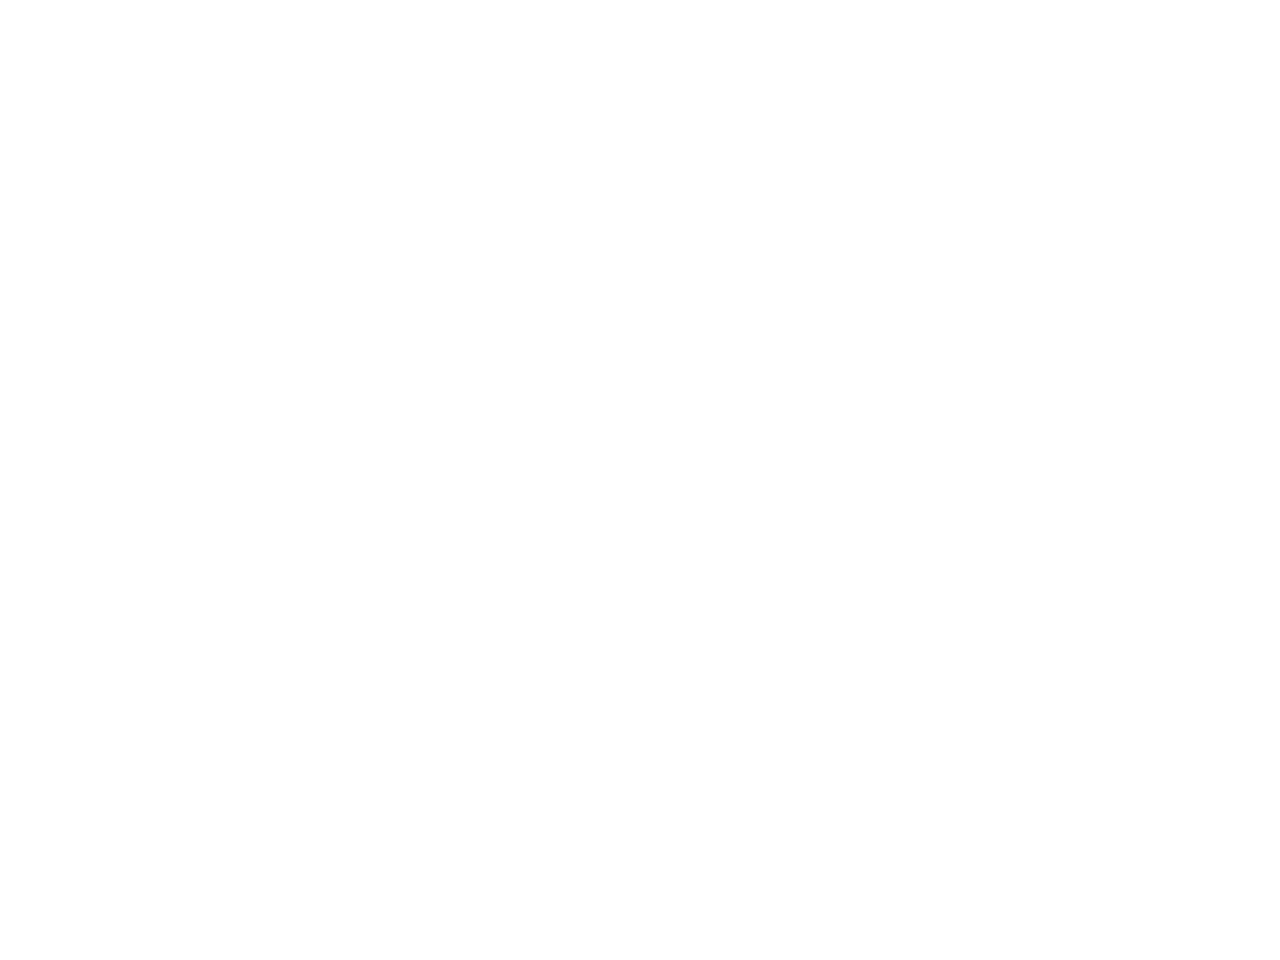

<IPython.core.display.Javascript object>


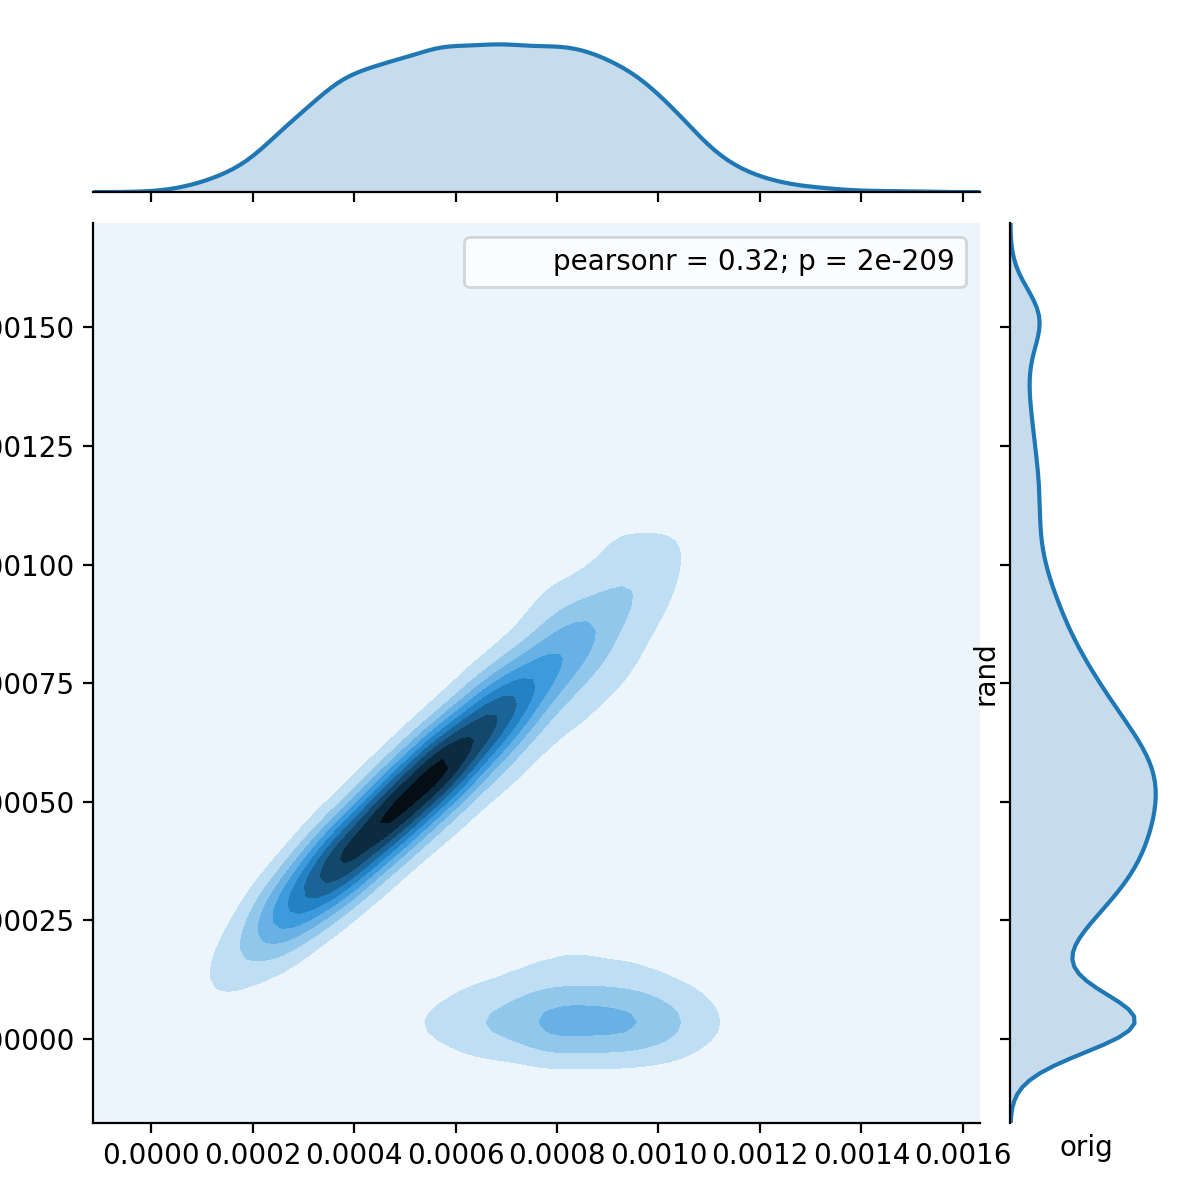

Text(468.016,0.5,'rand')

In [147]:
plt.figure()
sns.jointplot(np_all_rem_cmp_orig_adv[:, 0], np_all_rem_cmp_orig_adv[:, 2], kind="kde")
plt.xlabel("orig")
plt.ylabel("rand")

<IPython.core.display.Javascript object>


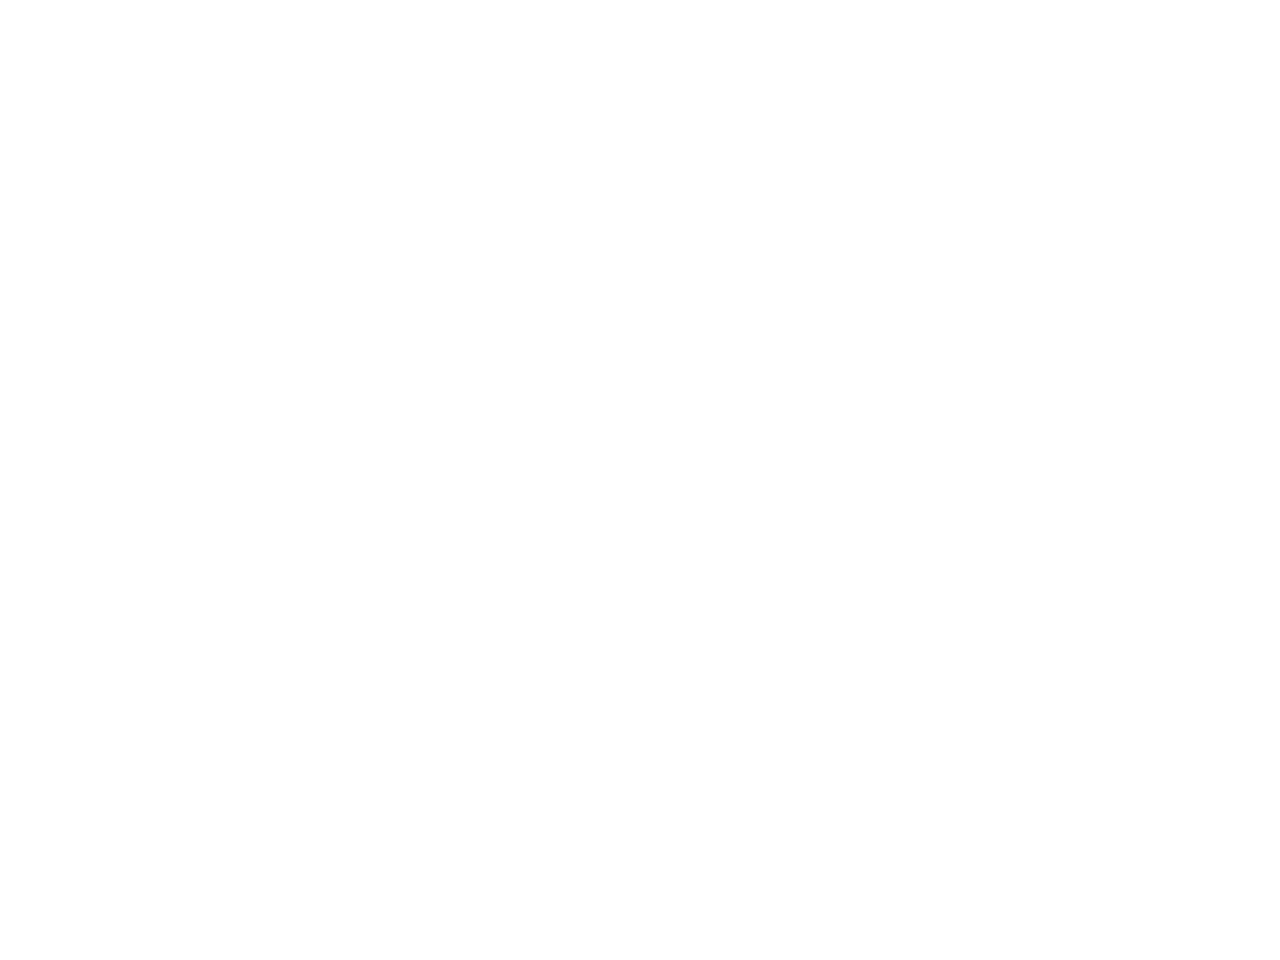

<IPython.core.display.Javascript object>


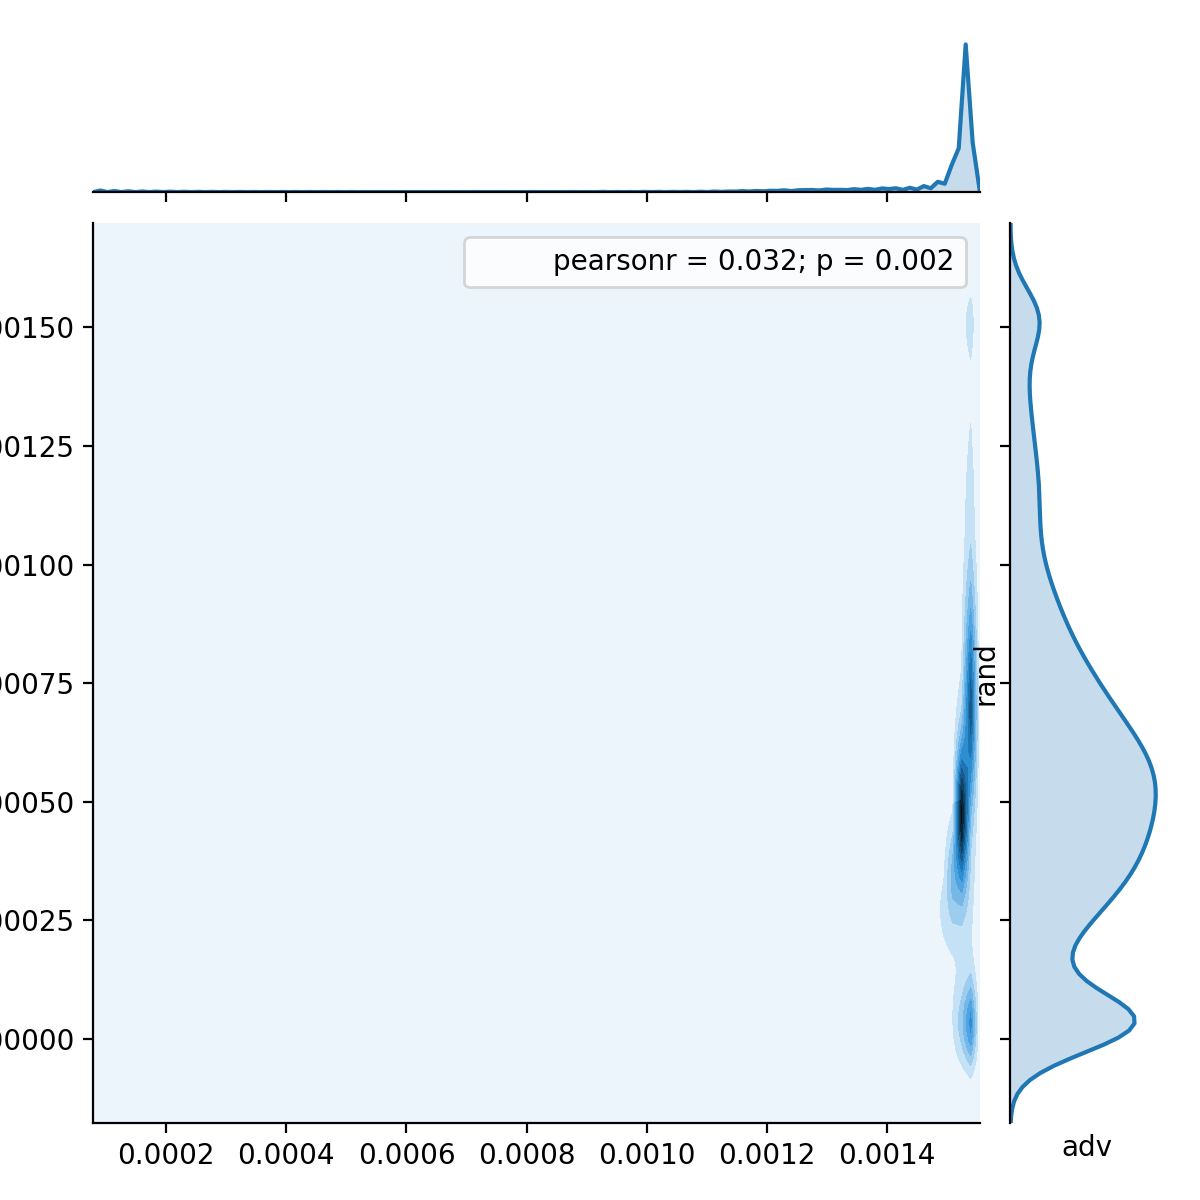

Text(468.016,0.5,'rand')

In [149]:
plt.figure()
sns.jointplot(np_all_rem_cmp_orig_adv[:, 1], np_all_rem_cmp_orig_adv[:, 2], kind="kde")
plt.xlabel("adv")
plt.ylabel("rand")